In [ ]:
# from psfsynth import *
# inst = 1
# ifield = 4-8
# filt_order = 3
# run_psf_synth(inst,ifield, filt_order=filt_order)

In [2]:
from reduction import *
from stack import * 
from psfstack import *

data_maps = {1: image_reduction(1), 2: image_reduction(2)}
mapin, strmask, strnum, mask_inst1, mask_inst2 = \
load_processed_images(data_maps, return_names=[(inst,ifield,'cbmap'), 
                                   (inst,ifield,'strmask'), 
                                   (inst,ifield,'strnum'),
                                   (1,ifield,'mask_inst'),
                                   (2,ifield,'mask_inst')])

inst = 1
psfdata_in = stack_psf(inst, data_maps[inst].stackmapdat,m_min=4, m_max=9,
                        Nsub_single=True, savedata=False, save_stackmap=True)
psfdata_mid = psfdata_in.copy()###
# psfdata_mid = stack_psf(inst, data_maps[inst].stackmapdat, m_min=13, m_max=14,
#                         Nsub_single=True, savedata=False, save_stackmap=True)
# for ifield in [4,5,6,7,8]:
#     run_psf_synth(inst,ifield)

# inst = 2
# psfdata_in = stack_psf(inst, data_maps[inst].stackmapdat,
#                 m_min=4, m_max=9, Nsub_single=True, savedata=False)
# psfdata_mid = stack_psf(inst, data_maps[inst].stackmapdat,
#                 m_min=13, m_max=14, Nsub_single=True, savedata=False)
# for ifield in [4,5,6,7,8]:
#     run_psf_synth(inst,ifield)

In [178]:
inst = 1
ifield = 5

fname = mypaths['alldat'] + 'TM'+ str(inst) + \
'/psfdata_synth_%s.pkl'%(fieldnamedict[ifield])
with open(fname, "rb") as f:
    profdat_old = pickle.load(f) ###

###
profdat = {}
profdat['rbins'] = profdat_old['rbins']
profdat['rbinedges'] = profdat_old['rbinedges']
profdat['rsubbins'] = profdat_old['rsubbins']
profdat['rsubbinedges'] = profdat_old['rsubbinedges']
profdat['filt_order'] = profdat_old['filt_order']
profdat['out']=  profdat_old['in']
profdat['mid']=  profdat_old['mid']
profdat[0] = profdat_old[0]
profdat[1] = profdat_old[1]
profdat[2] = profdat_old[2]
profdat[3] = profdat_old[3]
###

for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    
    profc = np.zeros_like(profdat['out']['profcb'])
    profcsub = np.zeros_like(profdat['out']['profcbsub'])
    covc = np.zeros_like(profdat['out']['cov'])
    covcsub = np.zeros_like(profdat['out']['covsub'])

    norm_in = profdat[im]['profcb'][0]
    norm_mid = norm_in * profdat[im]['profcb'][8] / profdat['mid']['profcb'][8]
    norm_out = norm_mid * profdat['mid']['profcb'][10] / profdat['out']['profcb'][10]

    profc[:9] = profdat[im]['profcb'][:9].copy() * norm_in
    profc[9:11] = profdat['mid']['profcb'][9:11].copy() * norm_mid
    profc[11:] = profdat['out']['profcb'][11:].copy() * norm_out

    profcsub[:4] = profdat[im]['profcbsub'][:4].copy() * norm_in
    profcsub[4:6] = profdat['mid']['profcbsub'][4:6].copy() * norm_mid
    profcsub[6:] = profdat['out']['profcbsub'][6:].copy() * norm_out

    covc[:9,:9] = profdat[im]['cov'][:9,:9].copy() * norm_in**2
    covc[9:11,9:11] = profdat['mid']['cov'][9:11,9:11].copy() * norm_mid**2
    covc[11:,11:] = profdat['out']['cov'][11:,11:].copy() * norm_out**2

    covcsub[:4,:4] = profdat[im]['covsub'][:4,:4].copy() * norm_in**2
    covcsub[4:6,4:6] = profdat['mid']['covsub'][4:6,4:6].copy() * norm_mid**2
    covcsub[6:,6:] = profdat['out']['covsub'][6:,6:].copy() * norm_out**2

    profdat[im]['comb'] = {}
    profdat[im]['comb']['profcb'] = profc
    profdat[im]['comb']['profcb_err'] = np.sqrt(np.diag(covc))
    profdat[im]['comb']['profcbsub'] = profcsub
    profdat[im]['comb']['profcbsub_err'] = np.sqrt(np.diag(covcsub))
    profdat[im]['comb']['cov'] = covc
    profdat[im]['comb']['covsub'] = covcsub

In [118]:
def normalize_cov(cov):
    cov_rho = np.zeros_like(cov)
    for i in range(cov_rho.shape[0]):
        for j in range(cov_rho.shape[0]):
            if cov[i,i]==0 or cov[j,j]==0:
                cov_rho[i,j] = cov[i,j]
            else:
                cov_rho[i,j] = cov[i,j] / np.sqrt(cov[i,i]*cov[j,j])
    return cov_rho



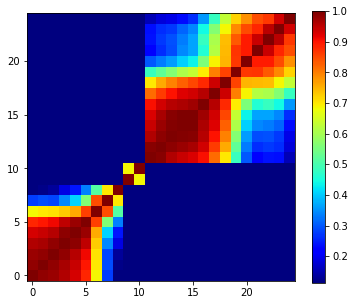

In [119]:
imageclip(normalize_cov(covc))

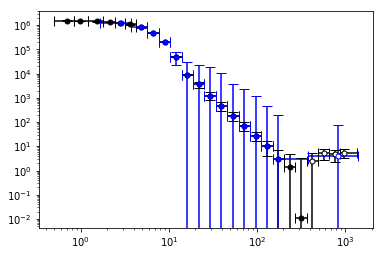

In [104]:
fig, ax = plt.subplots(1,1)
plot_err_log(profdat['rbins'], 
             profc,
             np.sqrt(np.diag(covc)),
             ax=ax, color='k',label='Source Stack')
plot_err_log(profdat['rsubbins'], 
             profcsub,
             np.sqrt(np.diag(covcsub)),
             ax=ax, color='b',label='Source Stack')

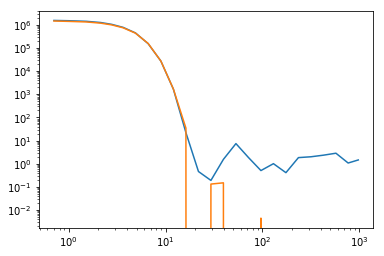

In [47]:
plt.loglog(profdat['rbins'],profdat[im]['profcb']*norm_in)
plt.loglog(profdat['rbins'],profdat['mid']['profcb']*norm_mid)
# plt.loglog(profdat['rbins'],profdat['in']['profcb']*norm_out)

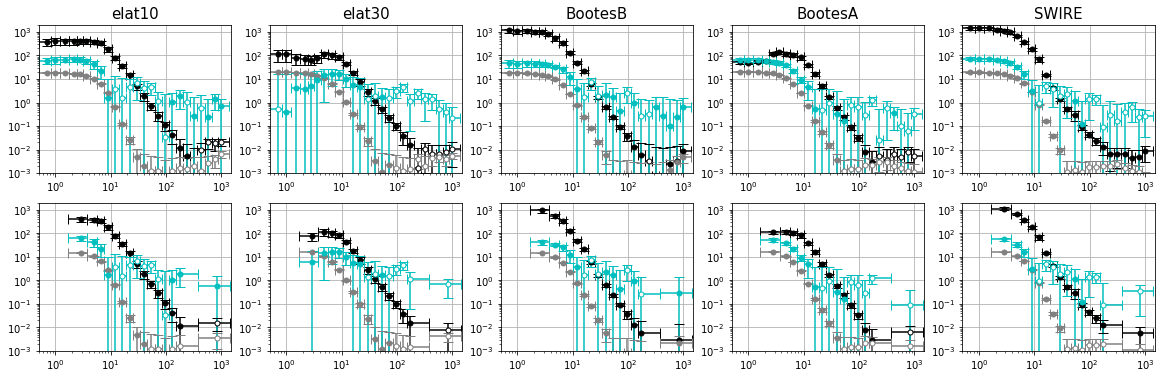

In [3]:
inst = 1
fig, ax = plt.subplots(2, 5, figsize = (20,6))
for i,ifield in enumerate([4,5,6,7,8]):
    fname = mypaths['alldat'] + 'TM'+ str(inst) + \
    '/psfdata_synth_%s.pkl'%(fieldnamedict[ifield])
    with open(fname, "rb") as f:
        profdat = pickle.load(f)
        
    plot_err_log(profdat['rbins'], 
                 profdat['in']['profcb'],
                 profdat['in']['profcb_err'],
                 ax=ax[0][i], color='k',label='Source Stack')
    
    plot_err_log(profdat['rbins'], 
                 profdat['mid']['profcb'],
                 profdat['mid']['profcb_err'],
                 ax=ax[0][i], color='grey',label='Source Stack')
    
    plot_err_log(profdat['rsubbins'], 
                 profdat['in']['profcbsub'],
                 profdat['in']['profcbsub_err'],
                 ax=ax[1][i], color='k',label='Source Stack')
    
    plot_err_log(profdat['rsubbins'], 
                 profdat['mid']['profcbsub'],
                 profdat['mid']['profcbsub_err'],
                 ax=ax[1][i], color='grey',label='Source Stack')

    im = 3
    plot_err_log(profdat['rbins'], 
                 profdat[im]['profcb'],
                 profdat[im]['profcb_err'],
                 ax=ax[0][i], color='c',label='Source Stack')
    plot_err_log(profdat['rsubbins'], 
                 profdat[im]['profcbsub'],
                 profdat[im]['profcbsub_err'],
                 ax=ax[1][i], color='c',label='Source Stack')

    ax[0][i].set_ylim([1e-3,2e3])
    ax[0][i].set_xlim([5e-1,1.5e3])
    ax[0][i].grid()    
    ax[0][i].set_title(fieldnamedict[ifield], fontsize=15)
    ax[1][i].set_ylim([1e-3,2e3])
    ax[1][i].set_xlim([5e-1,1.5e3])
    ax[1][i].grid()    

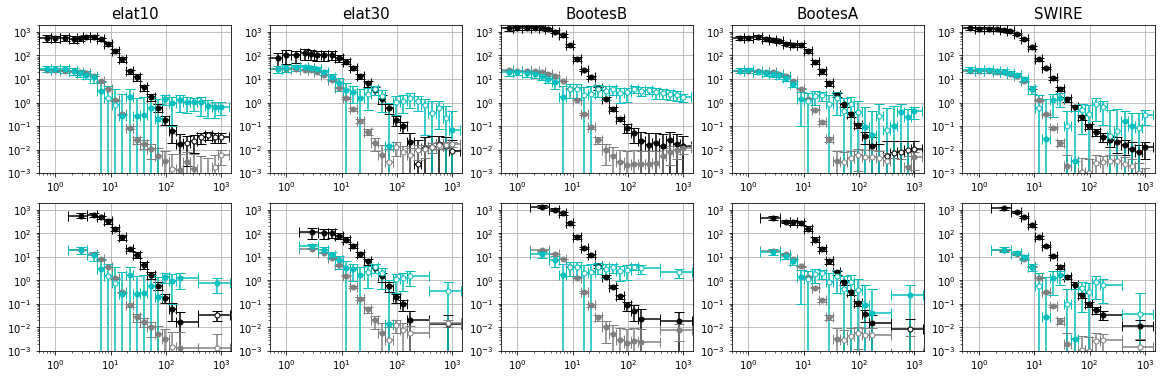

In [28]:
inst = 2
fig, ax = plt.subplots(2, 5, figsize = (20,6))
for i,ifield in enumerate([4,5,6,7,8]):
    fname = mypaths['alldat'] + 'TM'+ str(inst) + \
    '/psfdata_synth_%s.pkl'%(fieldnamedict[ifield])
    with open(fname, "rb") as f:
        profdat = pickle.load(f)
        
    plot_err_log(profdat['rbins'], 
                 profdat['in']['profcb'],
                 profdat['in']['profcb_err'],
                 ax=ax[0][i], color='k',label='Source Stack')
    
    plot_err_log(profdat['rbins'], 
                 profdat['mid']['profcb'],
                 profdat['mid']['profcb_err'],
                 ax=ax[0][i], color='grey',label='Source Stack')
    
    plot_err_log(profdat['rsubbins'], 
                 profdat['in']['profcbsub'],
                 profdat['in']['profcbsub_err'],
                 ax=ax[1][i], color='k',label='Source Stack')
    
    plot_err_log(profdat['rsubbins'], 
                 profdat['mid']['profcbsub'],
                 profdat['mid']['profcbsub_err'],
                 ax=ax[1][i], color='grey',label='Source Stack')

    im = 3
    plot_err_log(profdat['rbins'], 
                 profdat[im]['profcb'],
                 profdat[im]['profcb_err'],
                 ax=ax[0][i], color='c',label='Source Stack')
    plot_err_log(profdat['rsubbins'], 
                 profdat[im]['profcbsub'],
                 profdat[im]['profcbsub_err'],
                 ax=ax[1][i], color='c',label='Source Stack')

    ax[0][i].set_ylim([1e-3,2e3])
    ax[0][i].set_xlim([5e-1,1.5e3])
    ax[0][i].grid()    
    ax[0][i].set_title(fieldnamedict[ifield], fontsize=15)
    ax[1][i].set_ylim([1e-3,2e3])
    ax[1][i].set_xlim([5e-1,1.5e3])
    ax[1][i].grid()    